In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
from glob import glob
import json

In [2]:
ARC_LIST = [
    "dense-500m-arch1",
    "dense-1b-arch1",
    "dense-3b-arch1",
    "dense-500m-arch2",
    "dense-1b-arch2",
    "dense-3b-arch2",
]
task = "mmlu"
arc = ARC_LIST[-1]

In [124]:
files = sorted(glob(f"results/{task}/*{arc}*/*.jsonl"))

# first, create the dictionary with answer len and subject
file = files[0]
with open(file, "r") as f:
    data = [json.loads(line) for line in f]
df = pd.DataFrame(data)
questions_ll = df[["doc_id"]].copy()
questions_ll["answer_len"] = df.apply(lambda x : len(x["doc"]["choices"][x["doc"]["answer"]].split()), axis=1)
questions_ll["subject"] = df.apply(lambda x : x["doc"]["subject"], axis=1)

def max_ll(row):
    ll = [float(row["resps"][i][0][0]) for i in range(len(row["resps"])) if i != int(row["doc"]["answer"])]
    return np.mean(ll)

for file in files:
    with open(file, "r") as f:
        data = [json.loads(line) for line in f]
    df = pd.DataFrame(data)
    checkpoint = file.split("/")[2].split("iter_")[-1]
    questions_ll[int(checkpoint)] = df.apply(lambda x : float(x["resps"][x["doc"]["answer"]][0][0]), axis=1)
    questions_ll[f"{int(checkpoint)}_max"] = df.apply(lambda x : max_ll(x), axis=1)
    questions_ll[f"{int(checkpoint)}_diff"] = questions_ll[int(checkpoint)] - questions_ll[f"{int(checkpoint)}_max"]

In [ ]:
checkpoint_columns = [col for col in questions_ll.columns if type(col) == int]
def question_autocorr(row):
    return row[checkpoint_columns].autocorr()
def questions_norm_ll(row):
    ll = row[checkpoint_columns]
    ll = ll / row["answer_len"]
    return ll.mean()
questions_ll["autocorr"] = questions_ll.apply(question_autocorr, axis=1)
questions_ll["mean_ll"] = questions_ll[checkpoint_columns].mean(axis=1)
questions_ll["mean_ll_norm"] = questions_ll.apply(questions_norm_ll, axis=1)
questions_ll["mean_diff"] = questions_ll[[f"{col}_diff" for col in checkpoint_columns]].mean(axis=1)
questions_ll["mean_max"] = questions_ll[[f"{col}_max" for col in checkpoint_columns]].mean(axis=1)


## Data Analysis

### Does the length of the answer correlates with average log-likelihood?

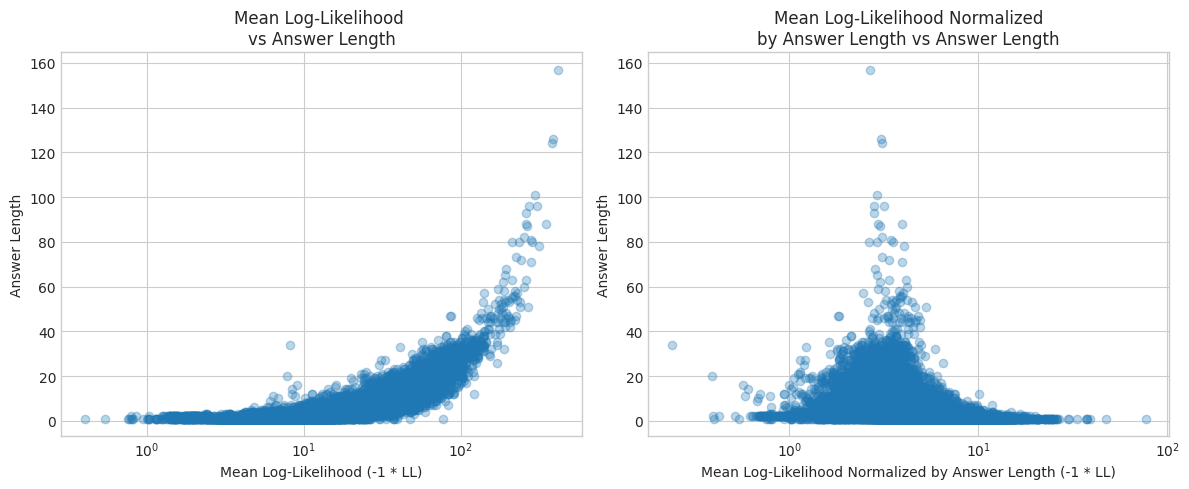

In [52]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(-questions_ll["mean_ll"], questions_ll["answer_len"], 'o', alpha=0.3)
plt.xlabel("Mean Log-Likelihood (-1 * LL)")
plt.ylabel("Answer Length")
plt.title(f"Mean Log-Likelihood \nvs Answer Length")
plt.xscale('log')

plt.subplot(1, 2, 2)
plt.plot(-questions_ll["mean_ll_norm"], questions_ll["answer_len"], 'o', alpha=0.3)
plt.xlabel("Mean Log-Likelihood Normalized by Answer Length (-1 * LL)")
plt.ylabel("Answer Length")
plt.title(f"Mean Log-Likelihood Normalized\nby Answer Length vs Answer Length")
plt.xscale('log')

plt.tight_layout()
plt.show()

### Questions that have good autocorrelation have which average log-likelihood?

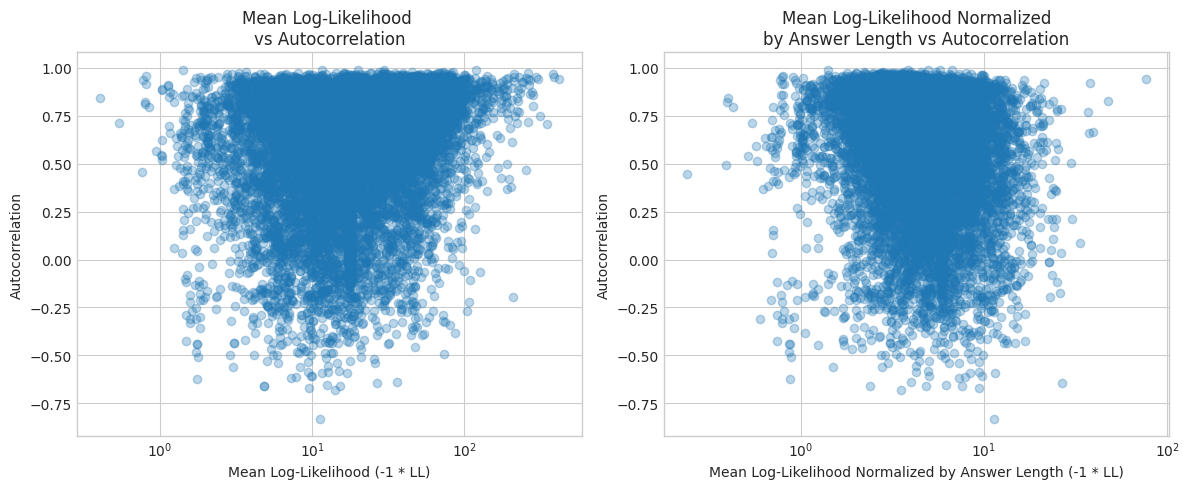

In [51]:
fig = plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(-questions_ll["mean_ll"], questions_ll["autocorr"], 'o', alpha=0.3)
plt.xlabel("Mean Log-Likelihood (-1 * LL)")
plt.ylabel("Autocorrelation")
plt.title(f"Mean Log-Likelihood \nvs Autocorrelation")
plt.xscale('log')

plt.subplot(1, 2, 2)
plt.plot(-questions_ll["mean_ll_norm"], questions_ll["autocorr"], 'o', alpha=0.3)
plt.xlabel("Mean Log-Likelihood Normalized by Answer Length (-1 * LL)")
plt.ylabel("Autocorrelation")
plt.title(f"Mean Log-Likelihood Normalized\nby Answer Length vs Autocorrelation")
plt.xscale('log')

plt.tight_layout()
plt.show()

### Are questions with good autocorrelation short?

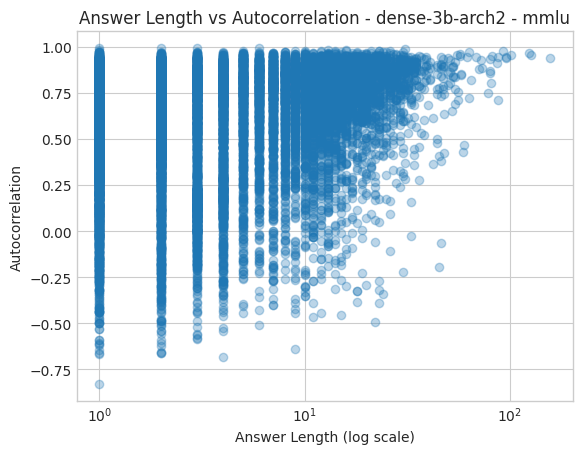

In [ ]:
plt.plot(questions_ll["answer_len"], questions_ll["autocorr"], 'o', alpha=0.3)
plt.xscale('log')
plt.xlabel("Answer Length (log scale)")
plt.ylabel("Autocorrelation")
plt.title(f"Answer Length vs Autocorrelation - {arc} - {task}")
plt.show()

### Does questions with high likelihood have high likelihood for all answers?

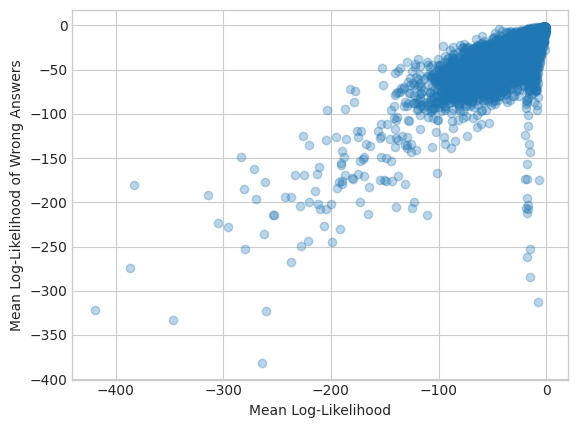

In [140]:
plt.scatter(
    questions_ll["mean_ll"],
    questions_ll["mean_max"],
    alpha=0.3
)
plt.xlabel("Mean Log-Likelihood")
plt.ylabel("Mean Log-Likelihood of Wrong Answers")
plt.show()

### For each subject, what is the average log-likelihood?

Text(0.5, 1.0, 'Average Log-Likelihood by Subject - dense-3b-arch2 - mmlu')

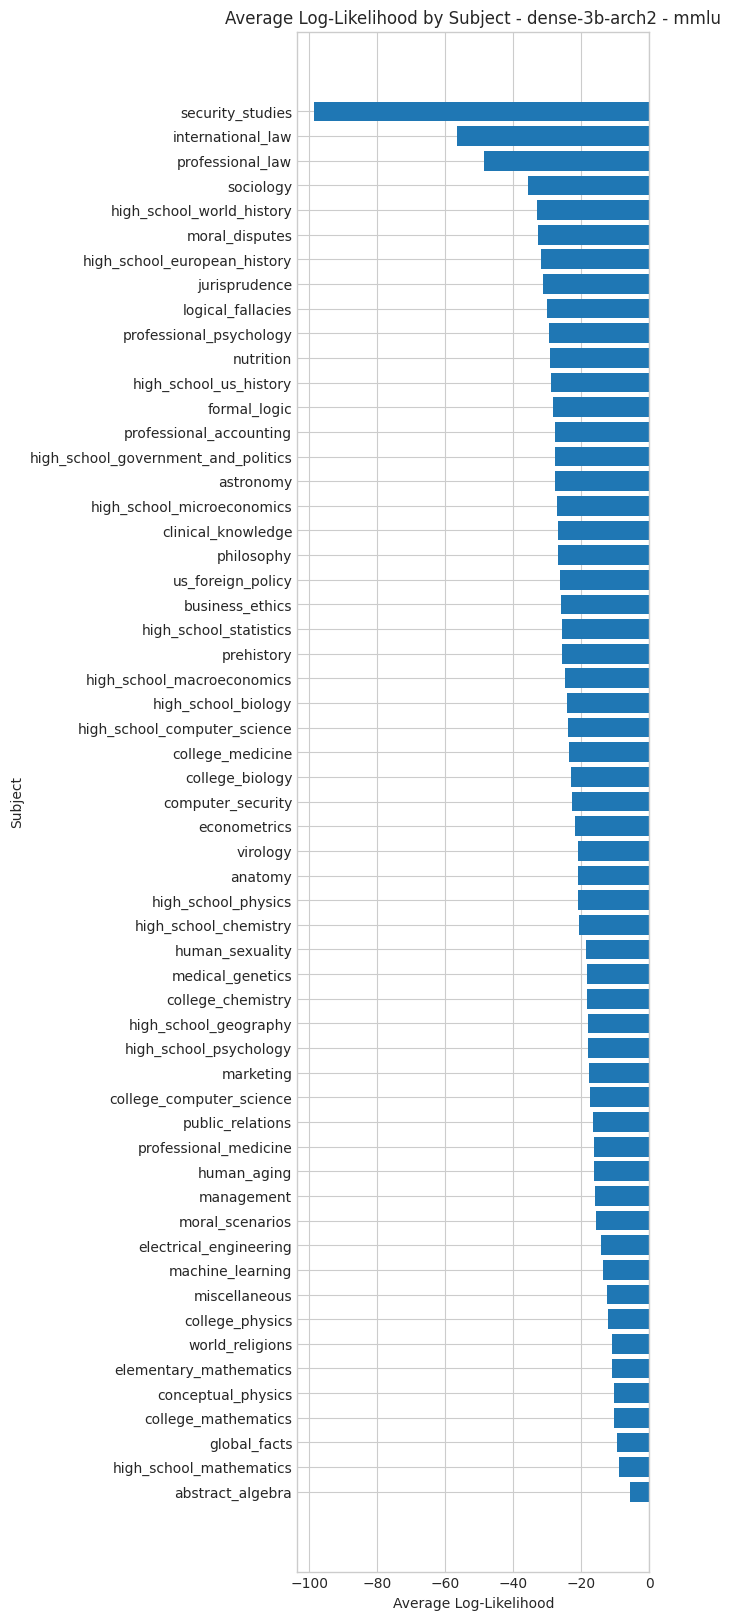

In [60]:
subject_avg = questions_ll.groupby("subject")[["mean_ll", "mean_ll_norm"]].mean().reset_index().sort_values(by="mean_ll", ascending=False)
fig = plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.barh(subject_avg["subject"], subject_avg["mean_ll"])
plt.ylabel("Subject")
plt.xlabel("Average Log-Likelihood")
plt.title(f"Average Log-Likelihood by Subject - {arc} - {task}")

Text(0.5, 1.0, 'Average Log-Likelihood Normalized by Answer Length by Subject - dense-3b-arch2 - mmlu')

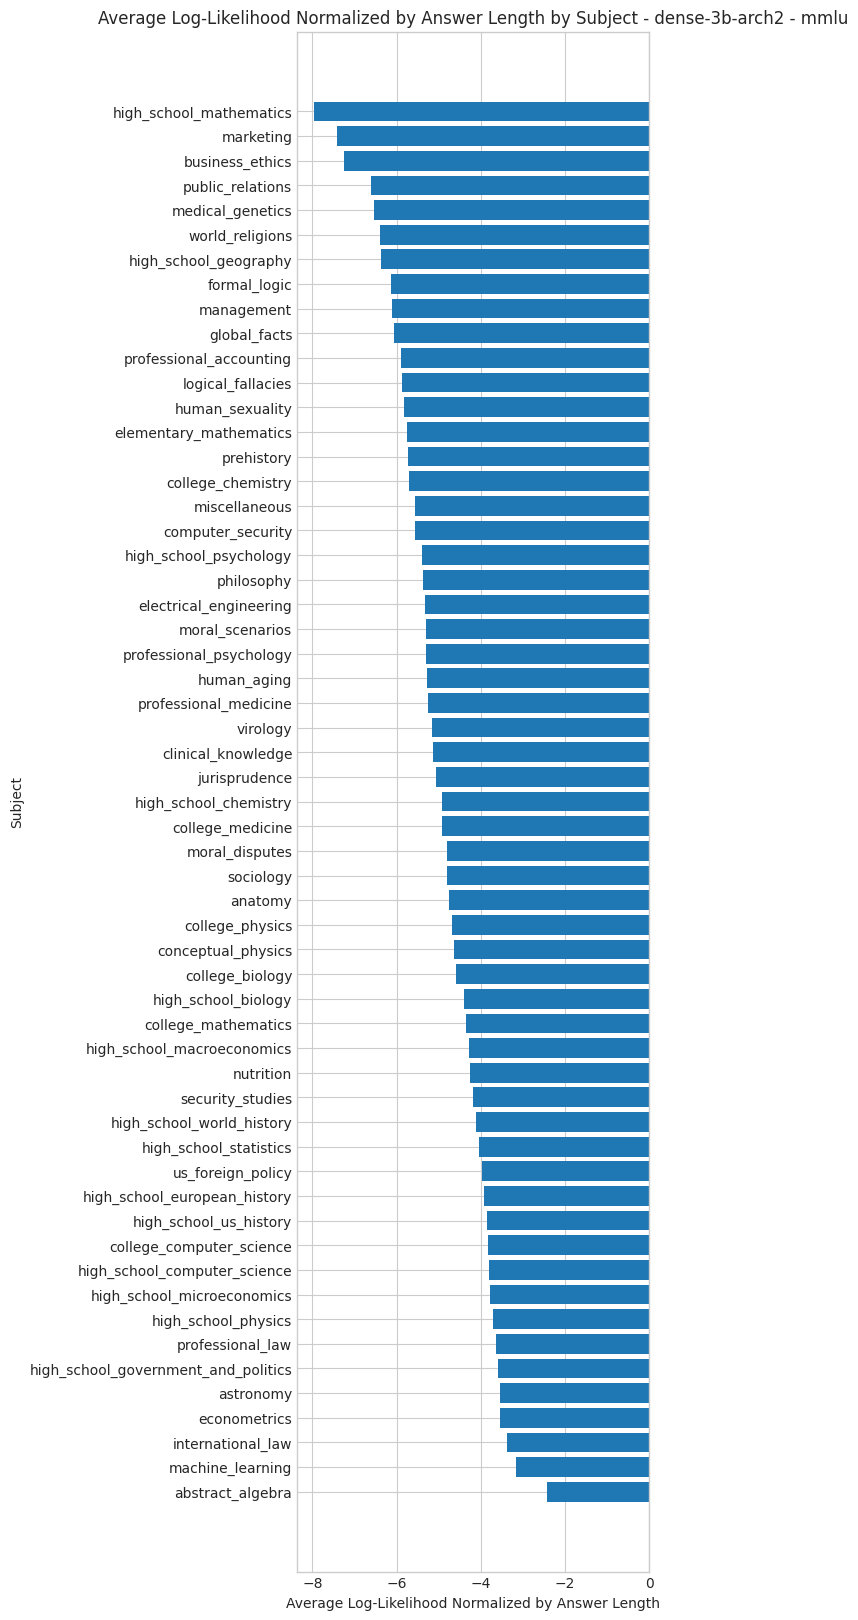

In [62]:
subject_avg = questions_ll.groupby("subject")[["mean_ll", "mean_ll_norm"]].mean().reset_index().sort_values(by="mean_ll_norm", ascending=False)
fig = plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.barh(subject_avg["subject"], subject_avg["mean_ll_norm"])
plt.ylabel("Subject")
plt.xlabel("Average Log-Likelihood Normalized by Answer Length")
plt.title(f"Average Log-Likelihood Normalized by Answer Length by Subject - {arc} - {task}")

### Is there any relation between the average log-likelihood and the average length of answer?

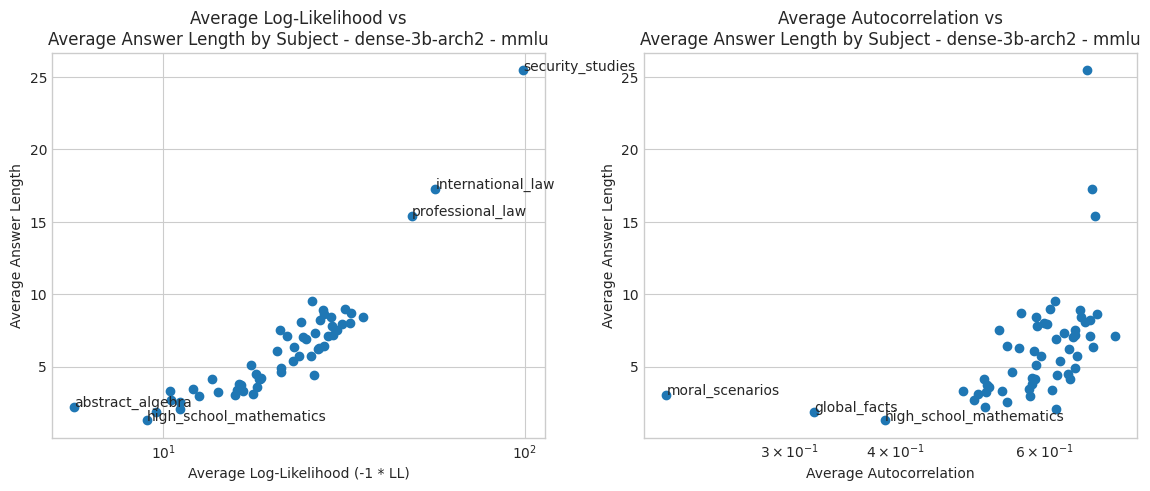

In [88]:
subject_avg = (
    questions_ll.groupby("subject")[["mean_ll", "mean_ll_norm", "answer_len", "autocorr"]]
    .mean()
    .reset_index()
    .sort_values(by="mean_ll_norm", ascending=False)
)


fig = plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)

plt.scatter(
    -subject_avg["mean_ll"],
    subject_avg["answer_len"],
)

plt.xscale('log')
plt.xlabel("Average Log-Likelihood (-1 * LL)")
plt.ylabel("Average Answer Length")
plt.title(f"Average Log-Likelihood vs\nAverage Answer Length by Subject - {arc} - {task}")

# add the name of the task with the highest average log-likelihood
for i, row in subject_avg.iterrows():
    if -row["mean_ll"] > 40:
        plt.text(-row["mean_ll"], row["answer_len"], row["subject"])
    if -row["mean_ll"] < 9:
        plt.text(-row["mean_ll"], row["answer_len"], row["subject"])

plt.subplot(1, 2, 2)


plt.scatter(
    subject_avg["autocorr"],
    subject_avg["answer_len"],
)

plt.xscale('log')
plt.xlabel("Average Autocorrelation")
plt.ylabel("Average Answer Length")
plt.title(f"Average Autocorrelation vs\nAverage Answer Length by Subject - {arc} - {task}")

# add the name of the task with the highest average log-likelihood
for i, row in subject_avg.iterrows():
    if row["autocorr"] < 0.45:
        plt.text(row["autocorr"], row["answer_len"], row["subject"])


plt.show()

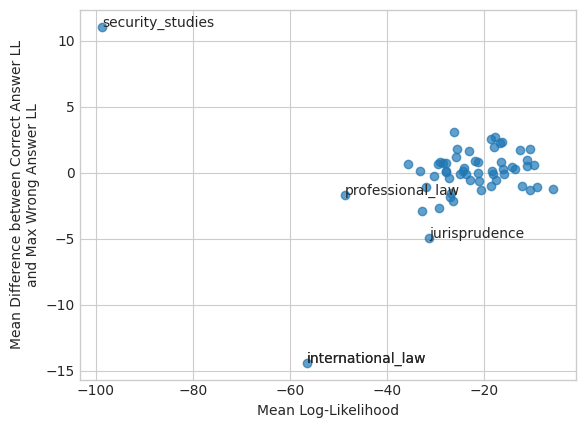

In [128]:
subject_avg = (
    questions_ll.groupby("subject")[["mean_ll", "mean_diff", "answer_len", "autocorr"]]
    .mean()
    .reset_index()
)

plt.scatter(
    subject_avg["mean_ll"],
    subject_avg["mean_diff"],
    alpha=0.7
)
plt.xlabel("Mean Log-Likelihood")
plt.ylabel("Mean Difference between Correct Answer LL\nand Max Wrong Answer LL")

for i, row in subject_avg.iterrows():
    if row["mean_ll"] < -40:
        plt.text(row["mean_ll"], row["mean_diff"], row["subject"])
    if row["mean_diff"] < -4:
        plt.text(row["mean_ll"], row["mean_diff"], row["subject"])

Text(0, 0.5, 'Log-Likelihood')

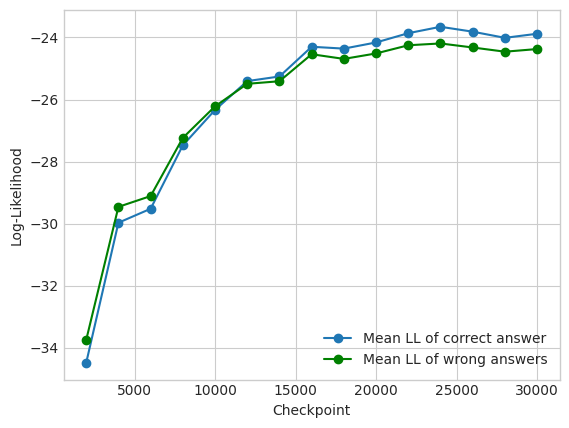

In [138]:
checkpoints_mean = questions_ll[checkpoint_columns].mean()
plt.plot(
    checkpoint_columns,
    checkpoints_mean,
    '-o',
    label='Mean LL of correct answer'
)

checkpoints_diff_mean = questions_ll[[f"{col}_max" for col in checkpoint_columns]].mean()
plt.plot(
    checkpoint_columns,
    checkpoints_diff_mean,
    '-o',
    color='green',
    label='Mean LL of wrong answers'
)
plt.legend()
plt.xlabel("Checkpoint")
plt.ylabel("Log-Likelihood")